<a href="https://colab.research.google.com/github/jobellet/fast_and_rich_decoding_in_VLPFC/blob/main/reproduce_monkeyH_PFC_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to the python notebook reproducing all the figures of the paper entitled:
# "Decoding rapidly presented visual stimuli from prefrontal ensembles without report nor post-perceptual processing"
\

In colab, you can simply run all the cells by pressing Ctrl+F9

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy.matlib
from skimage.measure import label
import seaborn as sb
from tqdm import tqdm



import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Arial"
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# functions for loading data
def get_monkeyH_df():
    try:
        df = pd.read_pickle('monkeyH.pkl')
    except:
        link_to_monkeyH_data = 'https://figshare.com/ndownloader/files/27946635'
        urllib.request.urlretrieve(link_to_monkeyH_data,'monkeyH.pkl')
        df = pd.read_pickle('monkeyH.pkl')
    return df

# functions for PSTH
def getSpikemat(spiketimes,mint=-.1,maxt=.4):
    '''
    Bin spiketimes at 1 kHz, single stimuli / trials
    '''
    t_total = int((maxt-mint)*1000) # total time bins
    nch = len(spiketimes)
    spikemat = np.zeros((nch,t_total)).astype(bool)
    for ch in range(nch):
        tms = np.round(spiketimes[ch]*1000).astype(int) - 1 #0-indexing
        
        tms = tms[(tms>=mint*1000) & (tms<maxt*1000)] - int(mint*1000)
        if len(tms)>0:
            spikemat[ch,tms] = 1
   
    return spikemat

def gen_time_bin(binsize,overlap,mint=-.1,maxt=.4):
    all_bins = []
    for i in range(int(binsize/overlap)):
        all_bins.append(np.arange(mint,maxt,binsize)+overlap*i)
    time_bins = np.sort(np.concatenate(all_bins)).astype(int)
    return(time_bins)

def rate_binning(spike_times,time_bins,binsize):
    time_bins = time_bins/1000 # convert in s
    binsize = binsize/1000 # convert in s
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return(average)

# function for cluster correction for multiple comparisons
def cluster_perm(real_data,permutations,pval_roi_threshold,pval_threshold):
    
    mean_perm = np.mean(permutations,axis = 0)
    std_perm = np.std(permutations,axis = 0)
    tval = (real_data-mean_perm)/std_perm
    pval = np.mean(np.matlib.repmat(real_data,permutations.shape[0],1) <= permutations,axis = 0)
    clusters = label(pval<pval_roi_threshold)
    sum_tvals = []
    significant_points = np.zeros_like(real_data).astype(bool)
    for i in range(max(clusters)):
        sum_tvals.append(sum(tval[clusters == (i+1)]))
    
    max_sum_tvals_perm = np.zeros(permutations.shape[0])
    for i in range(permutations.shape[0]):
        real_data_perm = permutations[i,:]
        tvalperm = (real_data_perm-mean_perm)/std_perm
        pvalperm = np.mean(np.matlib.repmat(real_data_perm,permutations.shape[0]-1,1) <= np.delete(permutations,i,axis = 0),axis = 0)
        clusters_perm = label(pvalperm<pval_roi_threshold)
        sum_tvals_perm = []
        for j in range(max(clusters_perm)):
            sum_tvals_perm.append(sum(tvalperm[clusters_perm == (j+1)]))
        
        if len(sum_tvals_perm)>0:
            max_sum_tvals_perm[i] = np.max(sum_tvals_perm)
    for i in range(max(clusters)):
        if np.mean(sum_tvals[i]<max_sum_tvals_perm)<pval_threshold:
            significant_points[clusters == (i+1)] = True
    return(significant_points)

# global parameters
nch = 96 # number of channels in the Utah array
sf = 30000; # sampling frequency
tmin = -100 #ms, time before each stim
tmax = 600 #ms, time after each stim

# parameters for binning and normalization
binsize = 50 #ms
overlap = 25 #ms
time_bins = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
df = get_monkeyH_df()

# Obtain normalized firing rate from spike time 

In [ ]:
compute_this_step = True # if set to False, to save time, this cell will just download the precomputed firing rate instead of reproducing this step

# download data from figshare
def get_monkeyH_firing_rate():
    try:
        Rb = np.load('monkeyH_PFC_raw_firing_rate.npy')
        Rc = np.load('monkeyH_PFC_normalized_firing_rate.npy')
        
    except:
        link_to_monkeyH_raw_firing_rate = 'https://figshare.com/ndownloader/files/28205322'
        urllib.request.urlretrieve(link_to_monkeyH_raw_firing_rate,'monkeyH_raw_firing_rate.npy')
        
        link_to_monkeyH_nomalized_firing_rate = 'https://figshare.com/ndownloader/files/28205325'
        urllib.request.urlretrieve(link_to_monkeyH_nomalized_firing_rate,'monkeyH_normalized_firing_rate.npy')
        Rb = np.load('monkeyH_raw_firing_rate.npy')
        Rc = np.load('monkeyH_normalized_firing_rate.npy')
    return Rb,Rc

if compute_this_step:
    # create PSTH of PFC channels 
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        Rb[tr,:] = rate_binning(df['Spikes'].iloc[tr],time_bins,binsize)
        
    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            Rc[df.sesID == sesID,ch,:] = (Rb[df.sesID == sesID,ch,:] - np.mean(Rb[df.sesID == sesID,ch,:])) / (np.std(Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    
    np.save('monkeyH_PFC_raw_firing_rate',Rb)
    np.save('monkeyH_PFC_normalized_firing_rate',Rc)
    
else:
    Rb,Rc, = get_monkeyH_firing_rate()

100%|██████████| 28672/28672 [15:18<00:00, 31.20it/s]


# Train with isolated stimuli PFC array

In [ ]:
compute_this_step = True # if set to False, to save time, this cell will just download the precomputed predictive probabilities of the classifier

nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)

if compute_this_step:
    K = 10 # number of training folds
    nbins = len(t) # number of time bins
    sessions = np.unique(np.array(df.sesID).astype(int))

    # index
    single_stim = (np.array(df.TrialID)>390)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
    single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset
    
    print(sum(single_stim))

    X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate of a channel needs to exceed 1Hz for it to be included in the classifier
    Y = np.array(df.StimID).astype(int)
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    Full_proba_matrix = np.zeros((ntr,nstim,nbins,nbins)) # predictive probability prealocation
    corresponding_proba = np.zeros((ntr,nbins)) # predictive probability for concerned item prealocation
    for k in range(K):
        print('Fold ',k+1,' / ',K)
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[single_stim[trainind]] # Keeping only long ISI for training 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
            for b2 in range(nbins):
                Full_proba_matrix[testind,:,b,b2] = model.predict_proba(X[testind,:,b2])
            corresponding_proba[testind,b] = np.squeeze(Proba[testind,Ytest,b])
    np.save('monkeyH_PFC_trainsingle_Coef.npy',Coef)# regression coefficient prealocation
    np.save('monkeyH_PFC_trainsingle_Proba.npy',Proba) # predictive probability prealocation
    np.save('monkeyH_PFC_trainsingle_Full_proba_matrix.npy',Full_proba_matrix) # predictive probability prealocation
    np.save('monkeyH_PFC_trainsingle_corresponding_proba.npy',corresponding_proba) # predictive probability for concerned item prealocation
else:
    monkeyH_PFC_trainsingle_Coef = 'https://figshare.com/ndownloader/files/27968259'
    urllib.request.urlretrieve(monkeyH_PFC_trainsingle_Coef,'monkeyH_PFC_trainsingle_Coef.npy')
    monkeyH_PFC_trainsingle_Proba = 'https://figshare.com/ndownloader/files/27968265'
    urllib.request.urlretrieve(monkeyH_PFC_trainsingle_Proba,'monkeyH_PFC_trainsingle_Proba.npy')
    monkeyH_PFC_trainsingle_Full_proba_matrix = 'https://figshare.com/ndownloader/files/27968262'
    urllib.request.urlretrieve(monkeyH_PFC_trainsingle_Full_proba_matrix,'monkeyH_PFC_trainsingle_Full_proba_matrix.npy')
    monkeyH_PFC_trainsingle_corresponding_proba = 'https://figshare.com/ndownloader/files/27968250'
    urllib.request.urlretrieve(monkeyH_PFC_trainsingle_corresponding_proba,'monkeyH_PFC_trainsingle_corresponding_proba.npy')

    Coef = np.load('monkeyH_PFC_trainsingle_Coef.npy')# regression coefficient prealocation
    Proba = np.load('monkeyH_PFC_trainsingle_Proba.npy') # predictive probability prealocation
    Full_proba_matrix = np.load('monkeyH_PFC_trainsingle_Full_proba_matrix.npy') # predictive probability prealocation
    corresponding_proba = np.load('monkeyH_PFC_trainsingle_corresponding_proba.npy') # predictive probability for concerned item prealocation
    single_stim = (np.array(df.TrialID)>390)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
    single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset
    

4039
Fold  1  /  10
Fold  2  /  10
Fold  3  /  10
Fold  4  /  10
Fold  5  /  10
Fold  6  /  10
Fold  7  /  10
Fold  8  /  10
Fold  9  /  10
Fold  10  /  10


## Figure S1A

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval
                                                        # add 50 ms to the time sample such that, on the plot every time bin references the last 50 ms of neural activity and not the upcoming 50 ms of neural activity
RSVP = np.array(df.duration >= 0.040) & np.array(df.duration <= 0.060) & np.array(df.TrialID < 110)
RSVP = RSVP & np.concatenate(([False],RSVP[:-1])) 

stimID = np.unique(np.array(df.StimID)).astype(int)
nperm = 2000

# create a surrogate accuracy traces from permuted label
# in stimuli presented inside a RSVP sequence
surrogate_accuracy_RSVP = np.zeros((len(stimID),nperm,len(t)))
for n in tqdm(stimID): # independently for each stimulus class
    for i in range(nperm):   
        temp = Proba[RSVP  & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_RSVP[n,i,:] = np.mean(temp2, axis = 0)



# create a surrogate accuracy traces from permuted label
# in stimuli presented in isolation
surrogate_accuracy_single_stim = np.zeros((len(stimID),nperm,len(t)))
for n in tqdm(stimID):
    for i in range(nperm):   
        temp = Proba[single_stim & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_single_stim[n,i,:] = np.mean(temp2, axis = 0)


## cluster correction    

significant_points_RSVP = np.zeros((len(stimID),len(t))).astype(bool)
for n in tqdm(stimID):
    surrogate_accuracy = np.argmax(Proba[RSVP & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(surrogate_accuracy, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_RSVP[n,:] = cluster_perm(real_data,surrogate_accuracy_RSVP[n,:],pval_roi_threshold,pval_threshold)

significant_points_single_stim = np.zeros((len(stimID),len(t))).astype(bool)

for n in tqdm(stimID):
    
    surrogate_accuracy = np.argmax(Proba[single_stim & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(surrogate_accuracy, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_single_stim[n,:] = cluster_perm(real_data,surrogate_accuracy_single_stim[n,:],pval_roi_threshold,pval_threshold)  
   

100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


#### Plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


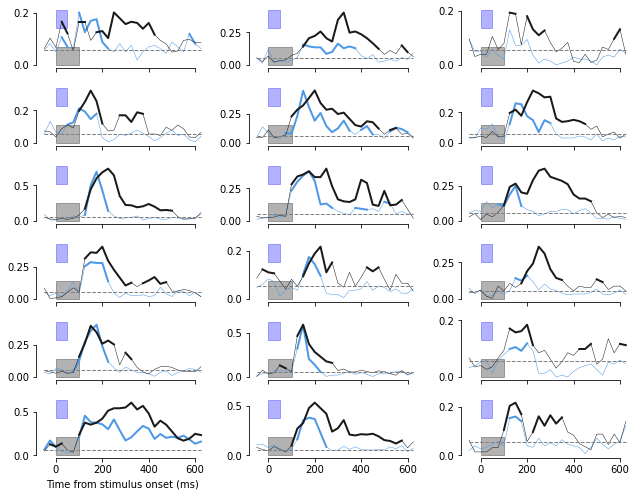

In [ ]:
## Draw the figure
lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]


fig,ax = plt.subplots(int(len(np.unique(df.StimID))/3),3,figsize = (9,7), sharey = False,sharex=True)
for n in np.unique(df.StimID).astype(int):
    # in RSVP
    hundreds = np.argmax(Proba[(df.TrialID == 100) & (df.ItemID<5) & (df.ItemID>1) & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblue,linewidth=.5,label = 'in RSVP')
    cluster = label(significant_points_RSVP[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblue,linewidth = 2)

    # in single stim
    hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblack,linewidth=.5,label = 'isolates stim')
    cluster = label(significant_points_single_stim[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblack,linewidth = 2)
    _,maxval = ax[np.mod(n,6),n//6].get_ylim()
    ax[np.mod(n,6),n//6].fill_between([0,100],[0,0],[maxval/3,maxval/3],color = 'k',alpha = 0.3)
    ax[np.mod(n,6),n//6].fill_between([0,50],[maxval*2/3,maxval*2/3],[maxval,maxval],color = 'b',alpha = 0.3)
    ax[np.mod(n,6),n//6].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[-1,0].set_xticks([0,200,400,600])
ax[-1,0].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('S1A.pdf')
fig.savefig('S1A.jpg',dpi = 600)


## Figure S2 A and B

[7.03396704e-05]
[7.96150865e-05]
[4.88105812e-05]
[3.21810091e-05]
[4.66198539e-05]
[4.87834009e-05]
[0.00011479]
[3.68474651e-05]
[4.14944278e-05]
[7.05981801e-05]
[6.20521141e-05]
[8.58116111e-05]
[6.79484711e-05]
[6.08912656e-05]
[0.00017046]
[0.00465555]


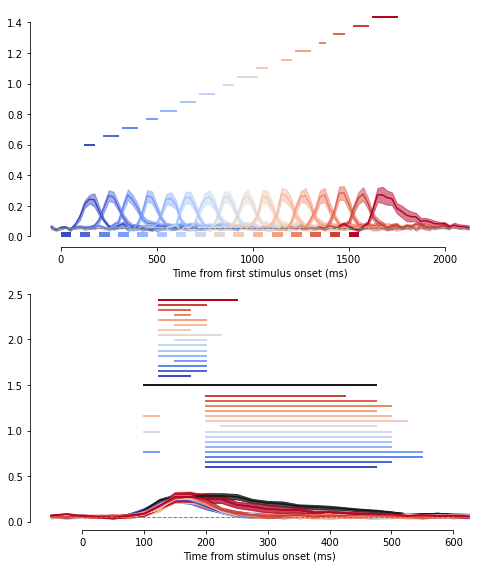

In [ ]:
RSVP_and_first_and_last = RSVP | (np.concatenate((np.diff(RSVP)==1,[False]))) | (np.concatenate(([False],np.diff(RSVP.astype(int))==-1)))

coolwarm = cm.get_cmap('coolwarm')
colors = np.linspace(0,1,16)
colors = coolwarm(colors)

lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]
single_stim = np.array(df.TrialID)>390
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))

stims = np.unique(df.StimID).astype(int)
all_RSVP = np.zeros((len(stims),len(t)))
all_single = np.zeros((len(stims),len(t)))

fig,ax = plt.subplots(2,1,figsize = (7,8))

for it in range(16):
    for n in stims:
        # in RSVP
        hundreds = np.argmax(Proba[RSVP_and_first_and_last &(df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        
        all_RSVP[n,:] = np.mean(hundreds, axis = 0)

        if it == 0:
            # in single stim
            hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
            all_single[n,:] = np.mean(hundreds, axis = 0)

    all_RSVP_mean = np.mean(all_RSVP, axis = 0)
    all_RSVP_std = np.std(all_RSVP, axis = 0)
    high_bound = all_RSVP_mean+all_RSVP_std/np.sqrt(all_RSVP.shape[0])
    low_bound = all_RSVP_mean-all_RSVP_std/np.sqrt(all_RSVP.shape[0])

    ax[0].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[0].plot(t+it*100,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    # VS chance stat
    corrected_stats = multipletests([stats.ttest_1samp(all_RSVP[:,x],1/18)[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.6, color = colors[it],linewidth = 2) 
        ax[0].plot(t[clusters==k]+it*100,np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 

    # VS single stim stat

    corrected_stats = multipletests([stats.ttest_rel(all_RSVP[:,x],all_single[:,x])[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    
    print(corrected_stats[1][t ==250])
    if it == 0:
        all_single_mean = np.mean(all_single, axis = 0)
        all_single_std = np.std(all_single, axis = 0)
        high_bound = all_single_mean+all_single_std/np.sqrt(all_single_mean.shape[0])
        low_bound = all_single_mean-all_single_std/np.sqrt(all_single_mean.shape[0])
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack)
        corrected_stats = multipletests([stats.ttest_1samp(all_single[:,x],1/18)[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
        clusters = label(corrected_stats[0])
        for k in np.arange(1,max(clusters)+1):
            ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.5, color = lightblack,linewidth = 2) 
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack) 
    #high_bound = all_RSVP_mean-all_single_mean+all_RSVP_std/np.sqrt(all_single.shape[0])
    #low_bound = all_RSVP_mean-all_single_mean-all_RSVP_std/np.sqrt(all_single.shape[0])
    #ax[1].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    #ax[1].plot(t+it*100,all_RSVP_mean-all_single_mean,color = colors[it])  


    ax[0].fill_between(np.array([0,50])+it*100,[0,0],[1/36,1/36],color = colors[it])
ax[0].plot([t[0],t[-1]+it*100],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[1].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)


    
ax[0].set_xlabel('Time from first stimulus onset (ms)')
ax[1].set_xticks([0,100,200,300,400,500,600])
ax[1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('Figure_S2A.pdf')
fig.savefig('Figure_S2A.jpg',dpi = 600)



## Figure S3A

100%|██████████| 2000/2000 [11:19<00:00,  2.94it/s]


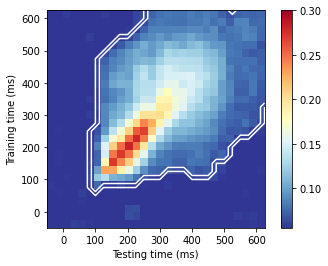

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval
                                                        # add 50 ms to the time sample such that, on the plot every time bin references the last 50 ms of neural activity and not the upcoming 50 ms of neural activity


target = np.array(df.StimID).astype(int)[single_stim]
target = np.repeat(target[:,np.newaxis],28,axis = 1)
target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

Full_proba_matrix_single_stim = Full_proba_matrix[single_stim,:]
generalization_accuracy = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==target,axis = 0)
nperm = 2000
perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
for i in tqdm(range(nperm)):
    randperm = np.random.permutation(len(target))
    temp_target = target[randperm,:]
    perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==temp_target,axis = 0)
pvals = np.mean(np.repeat(generalization_accuracy[:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)

fig,ax = plt.subplots(1,1)
im = ax.imshow(generalization_accuracy,origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                 cmap = 'RdYlBu_r',vmin = 1/18,vmax = .3)

fig.colorbar(im,ax=ax)

significant_map = np.reshape(corrected_stats[0],(len(t),len(t)))

ax.contour(significant_map,levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')

ax.set_xlabel('Testing time (ms)')
ax.set_ylabel('Training time (ms)')
fig.savefig('FigureS3A.pdf')
fig.savefig('FigureS3A.jpg',dpi = 600)

## Figure S3B

In [ ]:
significant_map = np.zeros((len(t),len(t),16))
generalization_accuracy = np.zeros((len(t),len(t),16))
for j in tqdm(range(16)):
    targ = (df.ItemID==(j+1) ) & RSVP_and_first_and_last
    
    target = np.array(df.StimID).astype(int)[targ]
    target = np.repeat(target[:,np.newaxis],28,axis = 1)
    target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

    Full_proba_matrix_RSVP = Full_proba_matrix[targ,:]
    generalization_accuracy[:,:,j] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==target,axis = 0)
    nperm = 2000
    perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
    for i in range(nperm):
        randperm = np.random.permutation(len(target))
        temp_target = target[randperm,:]
        perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==temp_target,axis = 0)
    pvals = np.mean(np.repeat(generalization_accuracy[:,:,j][:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
    
    corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    significant_map[:,:,j] = np.reshape(corrected_stats[0],(len(t),len(t)))
#corrected_pvals = corrected_pvals[1].resize(len(t),len(t))



100%|██████████| 16/16 [40:29<00:00, 151.84s/it]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


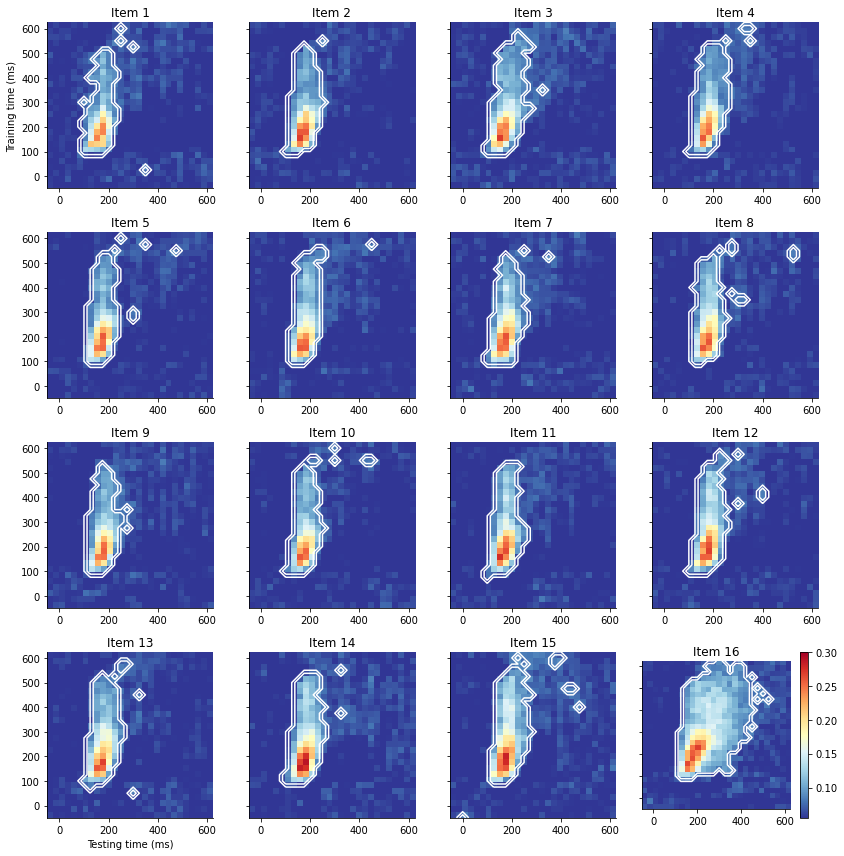

In [ ]:
vmin = 1/18
vmax = .3
fig,ax = plt.subplots(4,4,figsize = (12,12),sharey = True)
for j in range(16):
    
    im = ax[j//4,np.mod(j,4)].imshow(generalization_accuracy[:,:,j],origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                    cmap = 'RdYlBu_r',vmin = vmin,vmax = vmax)
    ax[j//4,np.mod(j,4)].contour(significant_map[:,:,j],levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
    ax[j//4,np.mod(j,4)].set_title('Item %d'%(j+1))
fig.colorbar(im,ax=ax[j//4,np.mod(j,4)])
ax[-1,0].set_xlabel('Testing time (ms)')
ax[0,0].set_ylabel('Training time (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('FigureS3B.pdf')
fig.savefig('FigureS3B.jpg',dpi = 600)

# Train with RSVP stimuli

In [ ]:
compute_this_step = True # Set to false to just download the precomputed predictive probability of classifiers trained with RSVP stimuli

nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)

RSVP = np.array(df.duration >= 0.040) & np.array(df.duration <= 0.060) & np.array(df.TrialID < 110)
RSVP = RSVP & np.concatenate(([False],RSVP[:-1])) & np.concatenate(([False],RSVP[1:]))

single_stim = np.array(df.TrialID)>390
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))

if compute_this_step:
    K = 10 # number of training folds
    nbins = len(t) # number of time bins
    sessions = np.unique(np.array(df.sesID).astype(int))

    # index
    

    training_stims = RSVP  # select only stimuli presentation being followed by an other stimulus 100 ms after the onset...

    print(sum(training_stims))

    X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
    Y = np.array(df.StimID).astype(int)
    ntr = X.shape[0]
    ntest = int(ntr/K)
    shuffle = np.random.permutation(ntr)# permutation of every trial
    Coef = np.zeros((nstim,X.shape[1],nbins,K) )# regression coefficient prealocation
    Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
    Full_proba_matrix = np.zeros((ntr,nstim,nbins,nbins)) # predictive probability prealocation
    corresponding_proba = np.zeros((ntr,nbins)) # predictive probability for concerned item prealocation
    for k in range(K):
        print('Fold ',k+1,' / ',K)
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:] 
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[training_stims[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)
            Coef[:,:,b,k] = model.coef_
            Proba[testind,:,b] = model.predict_proba(X[testind,:,b])
            for b2 in range(nbins):
                Full_proba_matrix[testind,:,b,b2] = model.predict_proba(X[testind,:,b2])
            corresponding_proba[testind,b] = np.squeeze(Proba[testind,Ytest,b])
    np.save('monkeyH_PFC_trainRSVP_Coef.npy',Coef)# regression coefficient prealocation
    np.save('monkeyH_PFC_trainRSVP_Proba.npy',Proba) # predictive probability prealocation
    np.save('monkeyH_PFC_trainRSVP_Full_proba_matrix.npy',Full_proba_matrix) # predictive probability prealocation
    np.save('monkeyH_PFC_trainRSVP_corresponding_proba.npy',corresponding_proba) # predictive probability for concerned item prealocation
else:
    
    try:
        Coef = np.load('monkeyH_PFC_trainRSVP_Coef.npy')# regression coefficient 
        Proba = np.load('monkeyH_PFC_trainRSVP_Proba.npy') # predictive probabilites for each class
        Full_proba_matrix = np.load('monkeyH_PFC_trainRSVP_Full_proba_matrix.npy') # predictive probabilites for GAT matrices
        corresponding_proba = np.load('monkeyH_PFC_trainRSVP_corresponding_proba.npy') # predictive probability for concerned item prealocation
    except:
        monkeyH_PFC_trainRSVP_Coef = 'https://figshare.com/ndownloader/files/28220922'
        urllib.request.urlretrieve(monkeyH_PFC_trainRSVP_Coef,'monkeyH_PFC_trainRSVP_Coef.npy')
        monkeyH_PFC_trainRSVP_Proba = 'https://figshare.com/ndownloader/files/28220925'
        urllib.request.urlretrieve(monkeyH_PFC_trainRSVP_Proba,'monkeyH_PFC_trainRSVP_Proba.npy')
        monkeyH_PFC_trainRSVP_Full_proba_matrix = 'https://figshare.com/ndownloader/files/28220949'
        urllib.request.urlretrieve(monkeyH_PFC_trainRSVP_Full_proba_matrix,'monkeyH_PFC_trainRSVP_Full_proba_matrix.npy')
        monkeyH_PFC_trainRSVP_corresponding_proba = 'https://figshare.com/ndownloader/files/28220946'
        urllib.request.urlretrieve(monkeyH_PFC_trainRSVP_corresponding_proba,'monkeyH_PFC_trainRSVP_corresponding_proba.npy')

        Coef = np.load('monkeyH_PFC_trainRSVP_Coef.npy')# regression coefficient prealocation
        Proba = np.load('monkeyH_PFC_trainRSVP_Proba.npy') # predictive probability prealocation
        Full_proba_matrix = np.load('monkeyH_PFC_trainRSVP_Full_proba_matrix.npy') # predictive probability prealocation
        corresponding_proba = np.load('monkeyH_PFC_trainRSVP_corresponding_proba.npy') # predictive probability for concerned item prealocation

11979
Fold  1  /  10
Fold  2  /  10
Fold  3  /  10
Fold  4  /  10
Fold  5  /  10
Fold  6  /  10
Fold  7  /  10
Fold  8  /  10
Fold  9  /  10
Fold  10  /  10


100%|██████████| 18/18 [00:19<00:00,  1.10s/it]


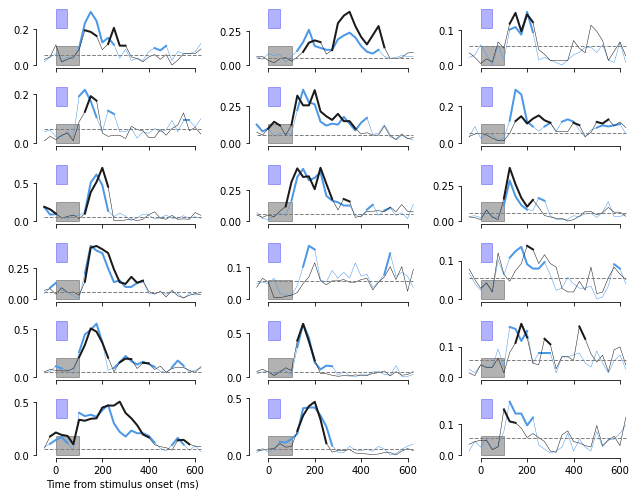

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is the upper end of each interval
nperm = 2000
stimID = np.unique(df.StimID).astype(int)
surrogate_accuracy_RSVP = np.zeros((len(stimID),nperm,len(t)))
# create a surrogate accuracy traces from permuted label
# in stimuli presented inside a RSVP sequence
for n in tqdm(stimID): # independently for each stimulus class
    for i in range(nperm):   
        temp = Proba[RSVP & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_RSVP[n,i,:] = np.mean(temp2, axis = 0)


surrogate_accuracy_single_stim = np.zeros((len(stimID),nperm,len(t)))

for n in tqdm(stimID):
    for i in range(nperm):   
        temp = Proba[single_stim & (df.StimID == n),:]
        for j in range(temp.shape[0]):
            randperm = np.random.permutation(len(stimID))
            temp[j,:] = temp[j,randperm,:]
        temp2 = np.argmax(temp,axis = 1) == n
        surrogate_accuracy_single_stim[n,i,:] = np.mean(temp2, axis = 0)


## cluster correction    

significant_points_RSVP = np.zeros((len(stimID),len(t))).astype(bool)
for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[(df.TrialID == 100)& (df.ItemID>1) & (df.ItemID<5) & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_RSVP[n,:] = cluster_perm(real_data,surrogate_accuracy_RSVP[n,:],pval_roi_threshold,pval_threshold)

significant_points_single_stim = np.zeros((len(stimID),len(t))).astype(bool)

for n in tqdm(stimID):
    # trained on hundreds
    hundreds = np.argmax(Proba[single_stim & (df.StimID == n),:],axis = 1) == n
    real_data = np.mean(hundreds, axis = 0)
    pval_roi_threshold = 0.01
    pval_threshold = 0.001 
    significant_points_single_stim[n,:] = cluster_perm(real_data,surrogate_accuracy_single_stim[n,:],pval_roi_threshold,pval_threshold)  

## Draw the figure
lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]


fig,ax = plt.subplots(int(len(np.unique(df.StimID))/3),3,figsize = (9,7), sharey = False,sharex=True)
for n in np.unique(df.StimID).astype(int):
    # in RSVP
    hundreds = np.argmax(Proba[(df.TrialID == 100) & (df.ItemID<5) & (df.ItemID>1) & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblue,linewidth=.5,label = 'in RSVP')
    cluster = label(significant_points_RSVP[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblue,linewidth = 2)

    # in single stim
    hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblack,linewidth=.5,label = 'isolates stim')
    cluster = label(significant_points_single_stim[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblack,linewidth = 2)
    _,maxval = ax[np.mod(n,6),n//6].get_ylim()
    ax[np.mod(n,6),n//6].fill_between([0,100],[0,0],[maxval/3,maxval/3],color = 'k',alpha = 0.3)
    ax[np.mod(n,6),n//6].fill_between([0,50],[maxval*2/3,maxval*2/3],[maxval,maxval],color = 'b',alpha = 0.3)
    ax[np.mod(n,6),n//6].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[-1,0].set_xticks([0,200,400,600])
ax[-1,0].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('FigureS1B.pdf')
fig.savefig('FigureS1B.jpg',dpi = 600)

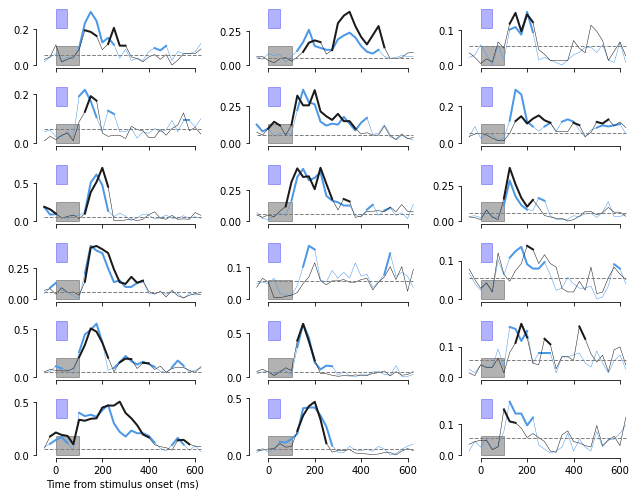

In [ ]:
## Draw the figure
lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]


fig,ax = plt.subplots(int(len(np.unique(df.StimID))/3),3,figsize = (9,7), sharey = False,sharex=True)
for n in np.unique(df.StimID).astype(int):
    # in RSVP
    hundreds = np.argmax(Proba[(df.TrialID == 100) & (df.ItemID<5) & (df.ItemID>1) & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblue,linewidth=.5,label = 'in RSVP')
    cluster = label(significant_points_RSVP[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblue,linewidth = 2)

    # in single stim
    hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
    ax[np.mod(n,6),n//6].plot(t,np.mean(hundreds, axis = 0), color = lightblack,linewidth=.5,label = 'isolates stim')
    cluster = label(significant_points_single_stim[n,:])
    for k in np.arange(1,max(cluster)+1):
        ax[np.mod(n,6),n//6].plot(t[cluster==k],np.mean(hundreds[:,cluster==k], axis = 0), color = lightblack,linewidth = 2)
    _,maxval = ax[np.mod(n,6),n//6].get_ylim()
    ax[np.mod(n,6),n//6].fill_between([0,100],[0,0],[maxval/3,maxval/3],color = 'k',alpha = 0.3)
    ax[np.mod(n,6),n//6].fill_between([0,50],[maxval*2/3,maxval*2/3],[maxval,maxval],color = 'b',alpha = 0.3)
    ax[np.mod(n,6),n//6].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[-1,0].set_xticks([0,200,400,600])
ax[-1,0].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('FigureS1B.pdf')
fig.savefig('FigureS1B.jpg',dpi = 600)

[0.54103889]
[0.92417372]
[0.9979377]
[0.85768353]
[0.99610674]
[0.95168925]
[0.98321311]
[0.98286974]
[0.90719559]
[0.90478522]
[0.95961114]
[0.93447859]
[0.754205]
[0.93796082]
[0.84644955]
[0.89006824]


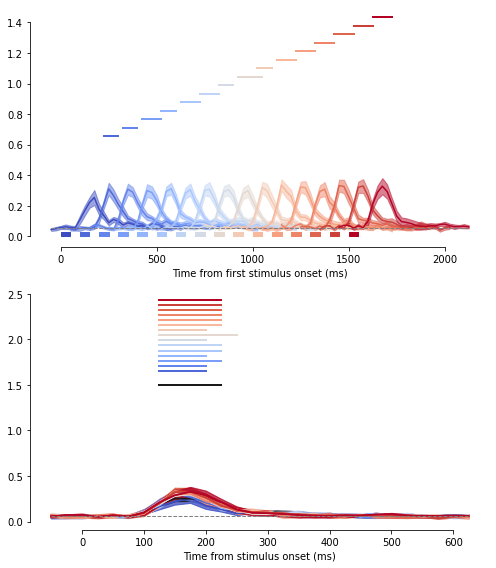

In [ ]:
RSVP_and_first_and_last = RSVP | (np.concatenate((np.diff(RSVP)==1,[False]))) | (np.concatenate(([False],np.diff(RSVP.astype(int))==-1)))

coolwarm = cm.get_cmap('coolwarm')
colors = np.linspace(0,1,16)
colors = coolwarm(colors)

lightblue = [0.3,0.6,0.9]
lightblack = [0.1,0.1,0.1]
single_stim = np.array(df.TrialID)>390
single_stim = single_stim & np.concatenate(([False],single_stim[:-1]))

stims = np.unique(df.StimID).astype(int)
all_RSVP = np.zeros((len(stims),len(t)))
all_single = np.zeros((len(stims),len(t)))

fig,ax = plt.subplots(2,1,figsize = (7,8))

for it in range(16):
    for n in stims:
        # in RSVP
        hundreds = np.argmax(Proba[RSVP_and_first_and_last &(df.ItemID == (it+1)) & (df.StimID == n),:],axis = 1) == n
        
        all_RSVP[n,:] = np.mean(hundreds, axis = 0)

        if it == 0:
            # in single stim
            hundreds = np.argmax(Proba[ single_stim & (df.StimID == n),:],axis = 1) == n
            all_single[n,:] = np.mean(hundreds, axis = 0)

    all_RSVP_mean = np.mean(all_RSVP, axis = 0)
    all_RSVP_std = np.std(all_RSVP, axis = 0)
    high_bound = all_RSVP_mean+all_RSVP_std/np.sqrt(all_RSVP.shape[0])
    low_bound = all_RSVP_mean-all_RSVP_std/np.sqrt(all_RSVP.shape[0])

    ax[0].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[0].plot(t+it*100,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    # VS chance stat
    corrected_stats = multipletests([stats.ttest_1samp(all_RSVP[:,x],1/18)[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.6, color = colors[it],linewidth = 2) 
        ax[0].plot(t[clusters==k]+it*100,np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 

    # VS single stim stat

    corrected_stats = multipletests([stats.ttest_rel(all_RSVP[:,x],all_single[:,x])[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
    clusters = label(corrected_stats[0])
    for k in np.arange(1,max(clusters)+1):
        ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+.6, color = colors[it],linewidth = 2) 
    ax[1].fill_between(t,high_bound,low_bound,color = colors[it],alpha = 0.5)
    ax[1].plot(t,np.mean(all_RSVP,axis = 0),color = colors[it]) 
    
    print(corrected_stats[1][t ==250])
    if it == 0:
        all_single_mean = np.mean(all_single, axis = 0)
        all_single_std = np.std(all_single, axis = 0)
        high_bound = all_single_mean+all_single_std/np.sqrt(all_single_mean.shape[0])
        low_bound = all_single_mean-all_single_std/np.sqrt(all_single_mean.shape[0])
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack)
        corrected_stats = multipletests([stats.ttest_1samp(all_single[:,x],1/18)[1] for x in range(len(t))], alpha=0.01, method='fdr_bh', is_sorted=False, returnsorted=False)
        clusters = label(corrected_stats[0])
        for k in np.arange(1,max(clusters)+1):
            ax[1].plot(t[clusters==k],np.ones(sum(clusters==k))*it/18+1.5, color = lightblack,linewidth = 2) 
        ax[1].fill_between(t,high_bound,low_bound,color = lightblack,alpha = 0.5)
        ax[1].plot(t,all_single_mean,color = lightblack) 
    #high_bound = all_RSVP_mean-all_single_mean+all_RSVP_std/np.sqrt(all_single.shape[0])
    #low_bound = all_RSVP_mean-all_single_mean-all_RSVP_std/np.sqrt(all_single.shape[0])
    #ax[1].fill_between(t+it*100,high_bound,low_bound,color = colors[it],alpha = 0.5)
    #ax[1].plot(t+it*100,all_RSVP_mean-all_single_mean,color = colors[it])  


    ax[0].fill_between(np.array([0,50])+it*100,[0,0],[1/36,1/36],color = colors[it])
ax[0].plot([t[0],t[-1]+it*100],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)
ax[1].plot([t[0],t[-1]],[1/18,1/18],'--',color = [.5,.5,.5],linewidth = 1)


    
ax[0].set_xlabel('Time from first stimulus onset (ms)')
ax[1].set_xticks([0,100,200,300,400,500,600])
ax[1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
sb.despine(trim = True)
plt.tight_layout()
fig.savefig('Figure_S2B.pdf')
fig.savefig('Figure_S2B.jpg',dpi = 600)



In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval

target = np.array(df.StimID).astype(int)[single_stim]
target = np.repeat(target[:,np.newaxis],28,axis = 1)
target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

Full_proba_matrix_single_stim = Full_proba_matrix[single_stim,:]
generalization_accuracy = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==target,axis = 0)
nperm = 2000
perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
for i in tqdm(range(nperm)):
    randperm = np.random.permutation(len(target))
    temp_target = target[randperm,:]
    perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_single_stim,axis = 1)==temp_target,axis = 0)
pvals = np.mean(np.repeat(generalization_accuracy[:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)


100%|██████████| 2000/2000 [11:13<00:00,  2.97it/s]


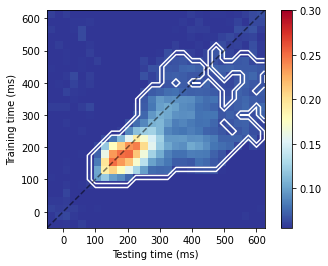

In [ ]:

fig,ax = plt.subplots(1,1)
im = ax.imshow(generalization_accuracy,origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                 cmap = 'RdYlBu_r',vmin = 1/18,vmax = .3)


fig.colorbar(im,ax=ax)

significant_map = np.reshape(corrected_stats[0],(len(t),len(t)))

ax.contour(significant_map,levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
plt.plot([t[0],t[-1]],[t[0],t[-1]],'--k',alpha = .5)
ax.set_xlabel('Testing time (ms)')
ax.set_ylabel('Training time (ms)')
fig.savefig('FigureS3C.pdf')
fig.savefig('FigureS3C.jpg',dpi = 600)

In [ ]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50 # the plotted time bin is upper end of each interval
significant_map = np.zeros((len(t),len(t),16))
generalization_accuracy = np.zeros((len(t),len(t),16))
for j in tqdm(range(16)):
    targ = (df.ItemID==(j+1) ) & RSVP_and_first_and_last
    
    target = np.array(df.StimID).astype(int)[targ]
    target = np.repeat(target[:,np.newaxis],28,axis = 1)
    target = np.repeat(target[:,:,np.newaxis],28,axis = 2)

    Full_proba_matrix_RSVP = Full_proba_matrix[targ,:]
    generalization_accuracy[:,:,j] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==target,axis = 0)
    nperm = 2000
    perm_generalization_accuracy = np.zeros((len(t),len(t),nperm))
    for i in range(nperm):
        randperm = np.random.permutation(len(target))
        temp_target = target[randperm,:]
        perm_generalization_accuracy[:,:,i] = np.mean(np.argmax(Full_proba_matrix_RSVP,axis = 1)==temp_target,axis = 0)
    pvals = np.mean(np.repeat(generalization_accuracy[:,:,j][:,:,np.newaxis],nperm,axis = 2)<=perm_generalization_accuracy,axis = 2)
    
    corrected_stats = multipletests(pvals.flatten(), alpha=0.001, method='fdr_bh', is_sorted=False, returnsorted=False)
    significant_map[:,:,j] = np.reshape(corrected_stats[0],(len(t),len(t)))
#corrected_pvals = corrected_pvals[1].resize(len(t),len(t))


100%|██████████| 16/16 [42:51<00:00, 160.70s/it]


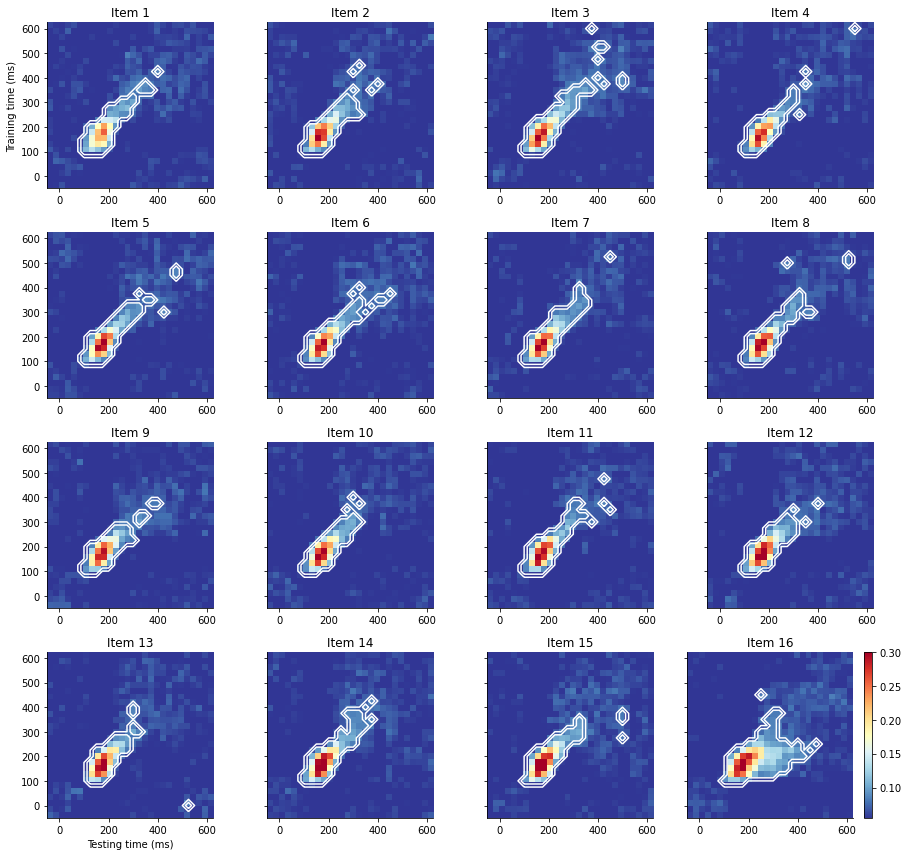

In [ ]:
vmin = 1/18
vmax = .3
fig,ax = plt.subplots(4,4,figsize = (13,12),sharey = True)
for j in range(16):
    im = ax[j//4,np.mod(j,4)].imshow(generalization_accuracy[:,:,j],origin='lower',extent=[t[0],t[-1],t[0],t[-1]],
                    cmap = 'RdYlBu_r',vmin = vmin,vmax = vmax)
    ax[j//4,np.mod(j,4)].contour(significant_map[:,:,j],levels=1,extent=[t[0],t[-1],t[0],t[-1]],colors='w')
    ax[j//4,np.mod(j,4)].set_title('Item %d'%(j+1))
    
fig.colorbar(im,ax=ax[j//4,np.mod(j,4)])
ax[-1,0].set_xlabel('Testing time (ms)')
ax[0,0].set_ylabel('Training time (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('FigureS3D.pdf')
fig.savefig('FigureS3D.jpg',dpi = 600)